# Lunar Lander Evaluation with Matrix Profile

The purpose of this notebook is to explore using using matrix profiles as a way to classify time series.  The data for this notebook consists of recorded "missions" for the Lunar Lander video game as provided by OpenAI Gym.  The missions are divided into two sets, the first is a set of missions that have been flown by a neural network that was trained with reinforcement learning.  The second is a set of missions that were flown by hand.  The goal is to determine how accurately classification with Matrix Profiles is at determining which is which.

We will begin by creating a single dataframe the consists of all of the missions.

In [1]:
#!pip install pandas
#!pip install stumpy

import pandas as pd
import numpy as np
from glob import glob
from math import sqrt

novice_mission_files = glob("./data/computer_missions_100/*.csv")
expert_mission_files = glob("./data/computer_missions_500/*.csv")

def get_file(filename, label):
    df_new = pd.read_csv(filename, header=None)
    df_new.columns = ['X','Y','XV', 'YV', 'Angle', 'Angular_Velocity', 'Leg_0_Ground', 'Leg_1_Ground']

    df_new['VM'] = df_new.apply(lambda row: sqrt(row['XV']**2+row['YV']**2), axis=1)

    
    df_new['XA'] = np.gradient(df_new['XV'])
    df_new['YA'] = np.gradient(df_new['YV'])
    df_new['AM'] = df_new.apply(lambda row: sqrt(row['XA']**2+row['YA']**2), axis=1)
        
    df_new['XJ'] = np.gradient(df_new['XA'])
    df_new['YJ'] = np.gradient(df_new['YA'])
    df_new['JM'] = df_new.apply(lambda row: sqrt(row['XJ']**2+row['YJ']**2), axis=1)
    
    
    df_new['Label']=label
    df_new['File']=filename.split("/")[-1]
    df_new['Idx']=[x for x in range(len(df_new))]
    df_new = df_new[['Idx','X','Y','XV', 'YV','VM', 'XA', 'YA', 'AM', 'XJ', 'YJ', 'JM', 'Angle', 'Angular_Velocity', 'Leg_0_Ground', 'Leg_1_Ground', 'File', 'Label']]
    return df_new

# Create random balanced training set.  N random novice and N expert files

expert_data_list = [{"File":f, "df":get_file(f, 'expert')} for f in expert_mission_files]
novice_data_list = [{"File":f, "df":get_file(f, 'novice')} for f in novice_mission_files]

print("We have {} expert files.".format(len(expert_data_list)))
print("We have {} novice files.".format(len(novice_data_list)))



We have 1000 expert files.
We have 1000 novice files.


In [2]:
import random

def split_list(l, p):
        random.shuffle(l)
        cut = int(len(l)*p)
        list_1 = l[:cut]
        list_2 = l[cut:]
        return(list_1, list_2)
    
novice_train, novice_test = split_list(novice_data_list, .8)
expert_train, expert_test = split_list(expert_data_list, .8)

print("We now have...")
print("Expert train: {} missions".format(len(expert_train)))
print("Expert test: {} missions".format(len(expert_test)))
print("Novice train: {} missions".format(len(novice_train)))
print("Novest test: {} missions".format(len(novice_test)))


We now have...
Expert train: 800 missions
Expert test: 200 missions
Novice train: 800 missions
Novest test: 200 missions


Now that we have data in a dataframes, the goal will be to create single time series of the training data, and then use matrix profile to match the samples in the test data to their closest fit in train.


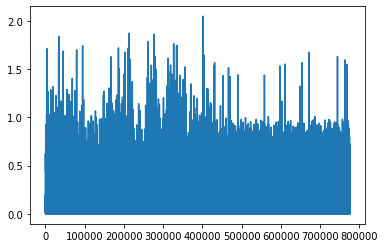

In [3]:
from matplotlib import pyplot as plt

ntds = [nt['df'] for nt in novice_train]
xtds = [et['df'] for et in expert_train]

train_df = pd.concat(ntds + xtds)

plt.plot(range(len(train_df)), train_df['VM'])


In [4]:
#!pip install stumpy
import stumpy

def search_for_similar(TA, TB):
    TA = TA[:300]
    
    tb_motif_index = -1
    m = len(TA)
    try:
        mp = stumpy.stump(T_A=TA, m=m, T_B=TB, ignore_trivial=False)

        motif_index = mp[:, 0].argmin()

        ta_motif_index = mp[:, 0].argmin()
        tb_motif_index = mp[ta_motif_index, 1]
    except Exception as exp:
        #print("Error:  {}".format(exp))
        pass
    
    return(tb_motif_index)


In [5]:
ee = 0
en = 0
ne = 0
nn = 0

n_test = [nt for nt in novice_test]
x_test = [et for et in expert_test]

test_files = n_test + x_test

ofiles = list()

for idx in range(len(test_files)):
    TA = test_files[idx]['df']['VM']
    act_label = test_files[idx]['df']['Label'][0]
    TB = np.array(train_df['VM']).astype(np.float64)
    result = search_for_similar(TA, TB)
    pred_label = train_df.iloc[result]['Label']
    
    if pred_label == 'expert':
        if act_label == 'expert':
            ee = ee + 1
        else:
            en = en + 1
    else:
        if act_label == 'novice':
            nn = nn + 1
        else:
            ne = ne + 1

accuracy = (nn+ee)/(nn+ne+en+ee)
       
print(accuracy)

0.935


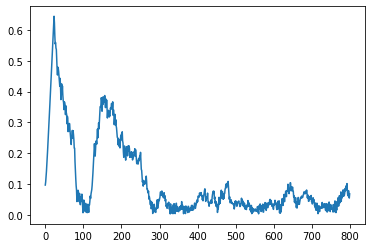

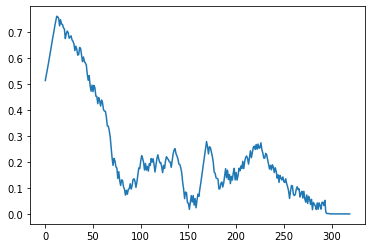

In [8]:
novice_sample = novice_train[167]['df'] 
expert_sample = expert_train[167]['df']
plt.plot(range(len(novice_sample)), novice_sample['VM'])
plt.show()
plt.plot(range(len(expert_sample)), expert_sample['VM'])
plt.show()

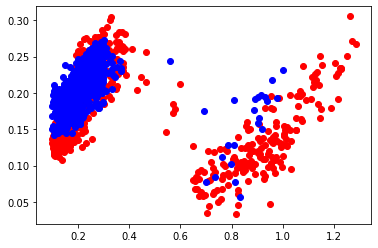

In [16]:
nm = [np.mean(x['df']['VM']) for x in novice_train]
ns = [np.std(x['df']['VM']) for x in novice_train]
xm = [np.mean(x['df']['VM']) for x in expert_train]
xs = [np.std(x['df']['VM']) for x in expert_train]

plt.scatter(nm,ns, c='red')
plt.scatter(xm,xs, c='blue')